<a href="https://colab.research.google.com/github/GulnazaS/image2latex/blob/main/image2latex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Скачивание утилит

In [ ]:
!pip install torchvision
!pip install tqdm
!pip install chardet
!pip install torchmetrics

# Импорт библиотек

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tarfile
import json
import chardet
from tensorflow.keras.preprocessing.text import Tokenizer

import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import gc

import torch
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

from torchmetrics import BLEUScore

import torch.nn as nn
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from tqdm.notebook import tqdm
import numpy as np

# Работа с набором данных

In [3]:
# Определяем кодировку файла
with open('/content/im2latex_formulas.lst', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

# Создаем пустой список для хранения значений
latex_formulas = []

# Открываем файл и читаем его содержимое
with open('/content//im2latex_formulas.lst', 'r', encoding=encoding) as f:
    for index, word in enumerate(f):
        # Добавляем слово с порядковым номером в список в формате словаря
        latex_formulas.append({
            "id": index + 1,  # Индекс + 1 для начала с 1
            "description": word.strip()  # Удаляем символ новой строки
        })

# Сохраняем список в формате JSON
with open('/content/im2latex_formulas.json', 'w', encoding='utf-8') as json_file:
    json.dump(latex_formulas, json_file, ensure_ascii=False, indent=4)

print("Список сохранен в формате JSON.")

Список сохранен в формате JSON.


In [11]:
def extract_tar(tar_path, extract_path):
    # Открываем и извлекаем содержимое архива
    try:
        with tarfile.open(tar_path, 'r:*') as tar:
            tar.extractall(path=extract_path)
            print(f"Файл {tar_path} успешно извлечен в {extract_path}.")
    except tarfile.TarError as e:
        print(f"Ошибка при разархивировании: {e}")

# Пример использования
tar_file_path = '/content/formula_images.tar.gz'  # Укажите путь к вашему архиву
extract_directory = '/content/'  # Укажите путь для извлечения
extract_tar(tar_file_path, extract_directory)

Файл /content/formula_images.tar.gz успешно извлечен в /content/.


In [7]:
# Определяем кодировку файла
with open('/content/im2latex_formulas.lst', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

# Создаем пустой список для хранения значений
latex_formulas = []

# Открываем файл и читаем его содержимое
with open('/content/im2latex_formulas.lst', 'r', encoding=encoding) as f:
    for index, word in enumerate(f):
        # Добавляем слово с порядковым номером в список в формате словаря
        latex_formulas.append({
            "id": index + 1,  # Индекс + 1 для начала с 1
            "description": word.strip()  # Удаляем символ новой строки
        })

# Сохраняем список в формате JSON
with open('/content/im2latex_formulas.json', 'w', encoding='utf-8') as json_file:
    json.dump(latex_formulas, json_file, ensure_ascii=False, indent=4)

print("Список сохранен в формате JSON.")

Список сохранен в формате JSON.


In [ ]:
latex_formulas[0]

{'id': 1,
 'description': "\\int_{-\\epsilon}^\\infty dl\\: {\\rm e}^{-l\\zeta}\t\\int_{-\\epsilon}^\\infty dl' {\\rm e}^{-l'\\zeta}\tll'{l'-l \\over l+l'} \\{3\\,\\delta''(l) - {3 \\over 4}t\\,\\delta(l) \\} =0.\t\t\\label{eq21}"}

In [8]:
def process_latex_images(file_path, output_path, latex_image):
    # Открываем файл и читаем его содержимое
    with open(file_path, 'r') as f:
        for index, line in enumerate(f):
            # Разделяем строку на элементы
            elements = line.strip().split()  # Удаляем символы новой строки и разделяем по пробелам
            if len(elements) >= 2:  # Проверяем, что в строке есть хотя бы два элемента
                latex_image.append({
                    "id": elements[0],  # Первый элемент - id
                    "image_id": f'{elements[1]}.png'  # Второй элемент - image_id
                })

    # Сохраняем список в формате JSON
    with open(output_path, 'w', encoding='utf-8') as json_file:
        json.dump(latex_image, json_file, ensure_ascii=False, indent=4)

    print(f"Список {output_path} сохранен в формате JSON.")

In [9]:
latex_image = []
process_latex_images('/content/im2latex_train.lst', '/content/im2latex.json', latex_image)

Список /content/im2latex.json сохранен в формате JSON.


In [ ]:
latex_image[0]

{'id': '1', 'image_id': '60ee748793.png'}

In [ ]:
latex_formulas[0]

{'id': 1,
 'description': "\\int_{-\\epsilon}^\\infty dl\\: {\\rm e}^{-l\\zeta}\t\\int_{-\\epsilon}^\\infty dl' {\\rm e}^{-l'\\zeta}\tll'{l'-l \\over l+l'} \\{3\\,\\delta''(l) - {3 \\over 4}t\\,\\delta(l) \\} =0.\t\t\\label{eq21}"}

In [10]:
df_formulas = pd.read_json('/content/im2latex_formulas.json')[:10000]
df_img = pd.read_json('/content/im2latex.json')[:10000]

In [12]:
def merge_datasets(df_img, df_formulas):
    # Объединяем DataFrame по столбцу 'id'
    df = pd.merge(df_img, df_formulas, on='id')
    return df

descriptions = merge_datasets(df_img, df_formulas)
descriptions

,id,image_id,description
0,1,60ee748793.png,\int_{-\epsilon}^\infty dl\: {\rm e}^{-l\zeta}...
1,2,66667cee5b.png,ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 +...
2,3,1cbb05a562.png,\widetilde\gamma_{\rm hopf}\simeq\sum_{n>0}\wi...
3,4,ed164cc822.png,"({\cal L}_a g)_{ij} = 0, \ \ \ \ ({\cal L}_a H..."
4,5,e265f9dc6b.png,S_{stat} = 2\pi \sqrt{N_5^{(1)} N_5^{(2)} N_5^...
...,...,...,...
8081,9995,11ab677532.png,\label{E12}ds_4^2 =- e^{\nu} dt^2 + e^{\l}dr^2...
8082,9997,1f02eed518.png,\Pi^{0}_{c} = \frac{\partial {\cal{L}}}{\part...
8083,9998,2d83b5cbed.png,\delta _{i}=\partial _{i}+w_{i}\partial _{4}+n...
8084,9999,71bf566307.png,\label{implusphi}\lim_{x\rightarrow +\infty} \...


In [13]:
descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8086 entries, 0 to 8085
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8086 non-null   int64 
 1   image_id     8086 non-null   object
 2   description  8086 non-null   object
dtypes: int64(1), object(2)
memory usage: 189.6+ KB


In [ ]:
image_file = descriptions.image_id.sample(1).iloc[0]
image_file

'719b5681e9.png'

1: D_+{\cal L}_-+D_-{\cal L}_++\{{\cal L}_+,{\cal L}_-\}=0


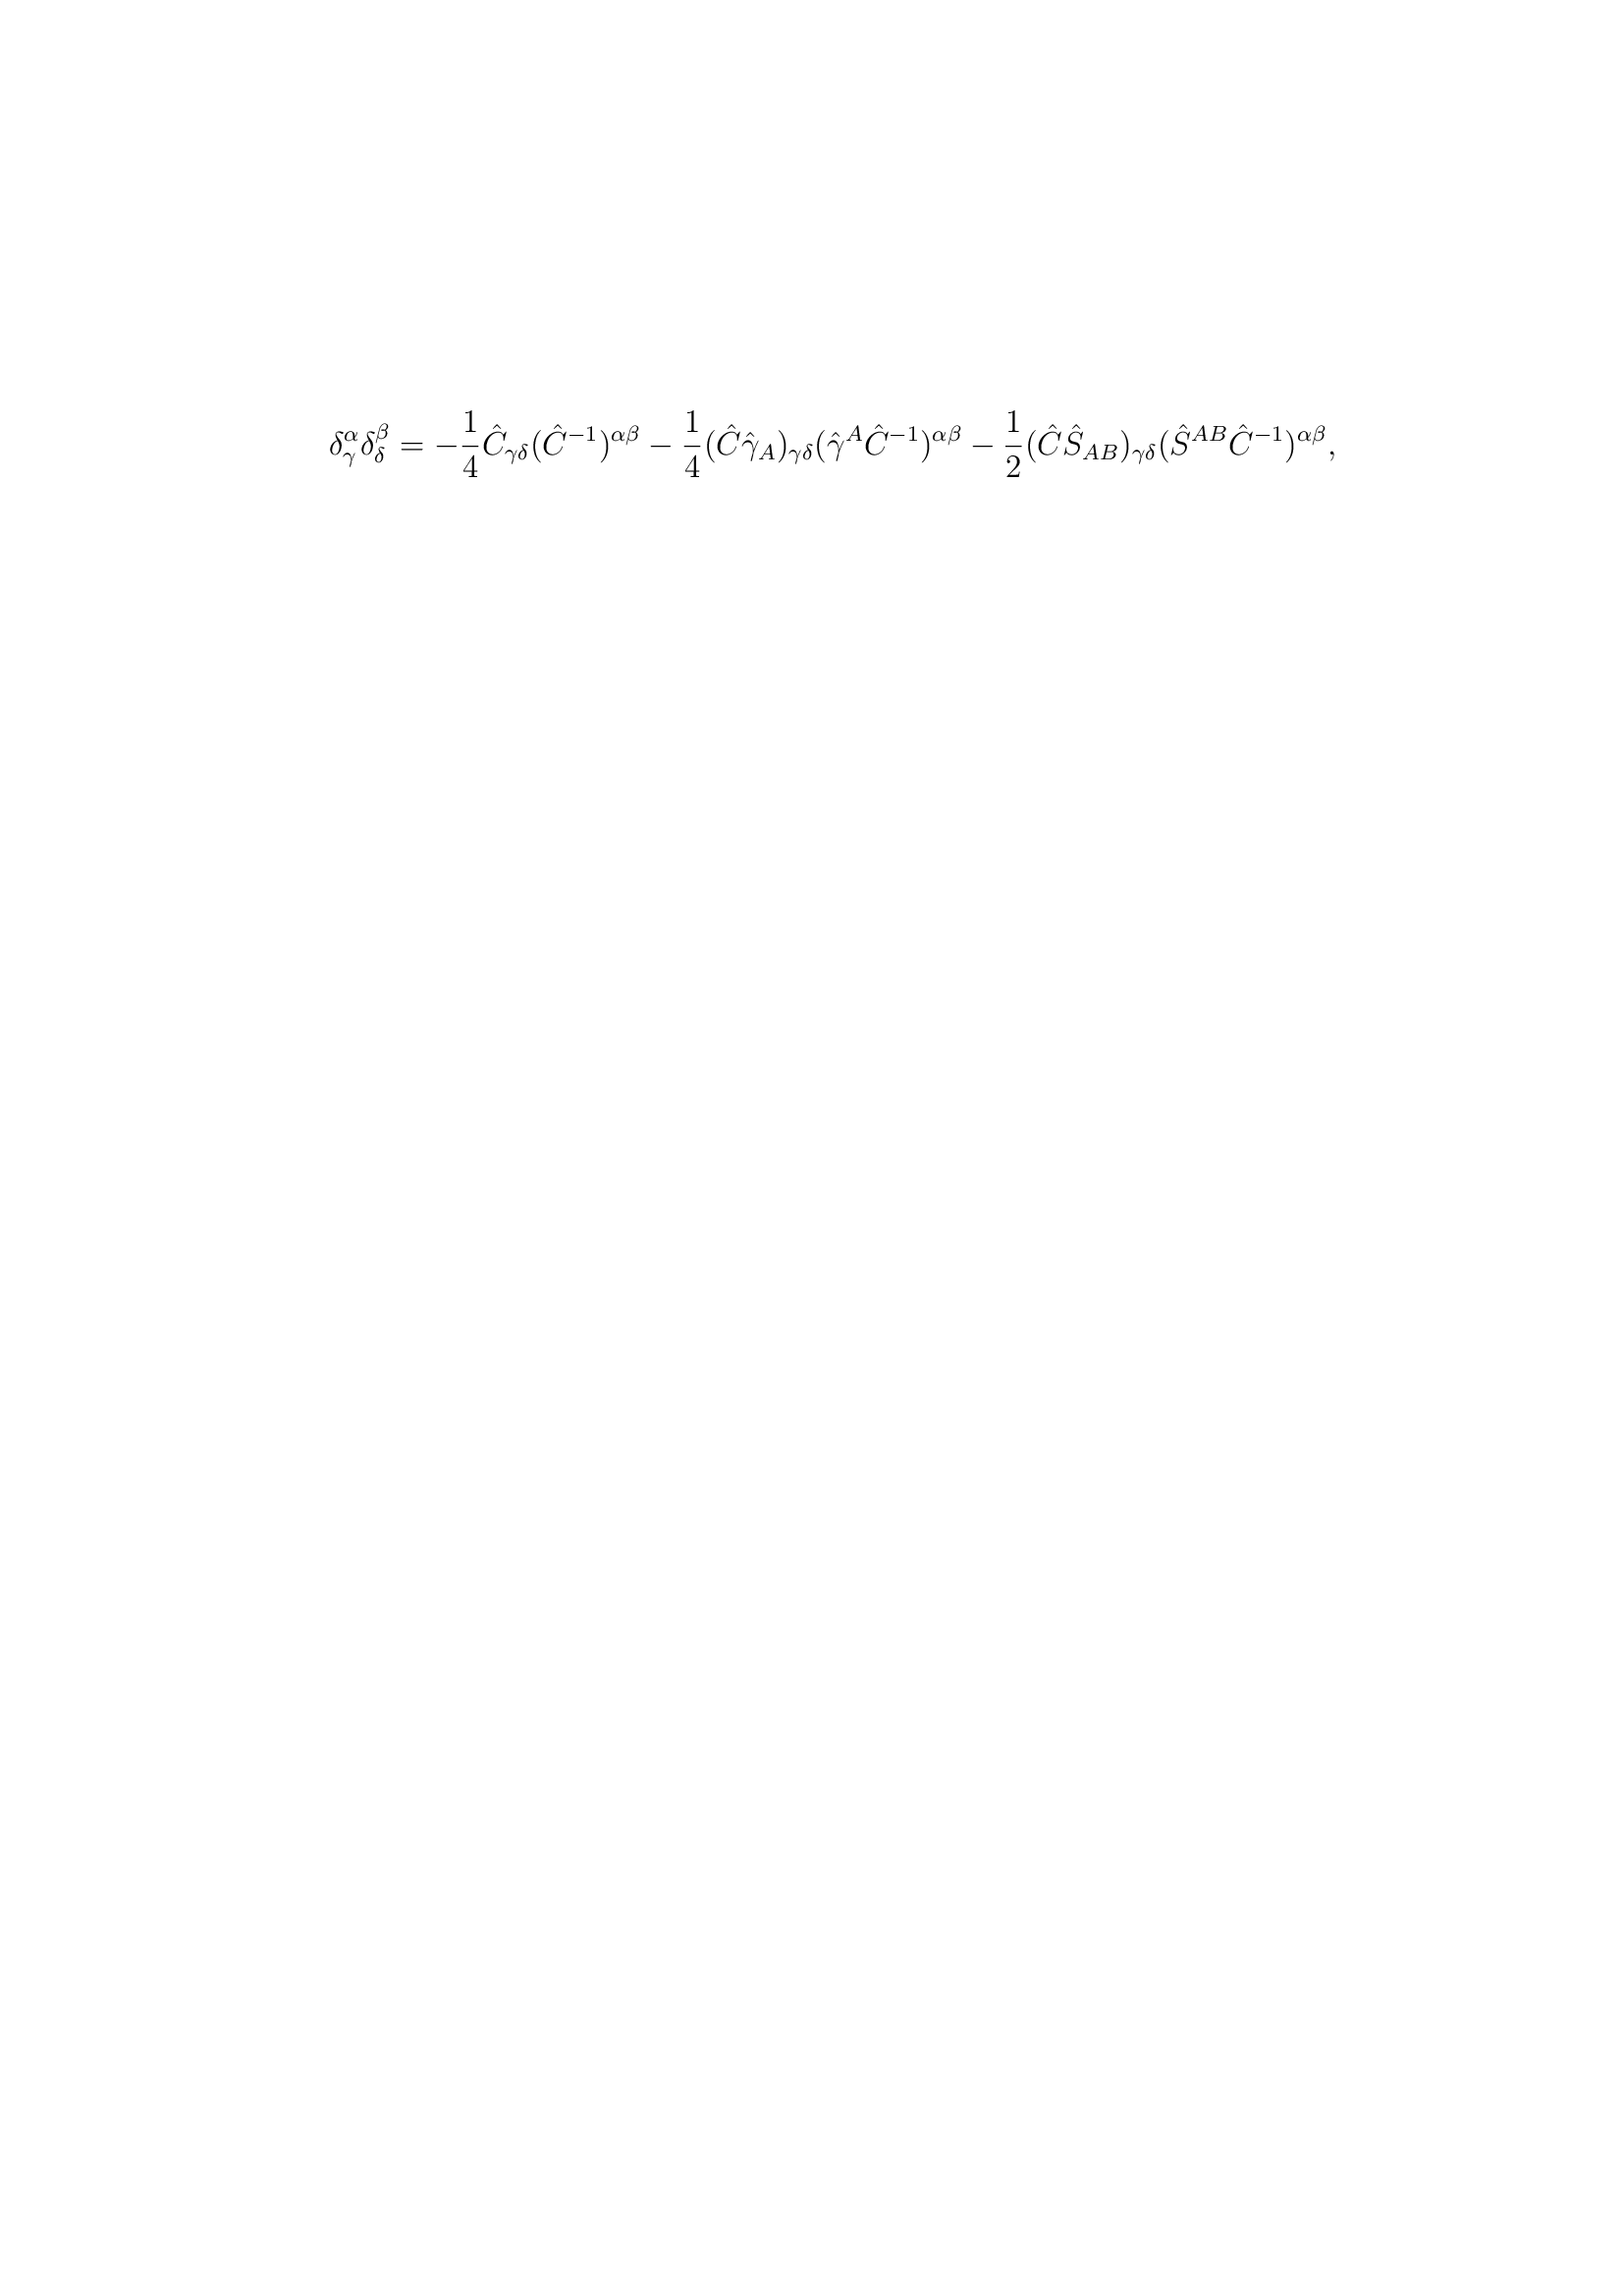

In [ ]:
image_file = descriptions.image_id.sample(1).iloc[0]
for i, description in enumerate(descriptions[descriptions.image_id == image_file].description):
    print(f'{i + 1}:', description)

# Открываем изображение
image_path = os.path.join('/content/formula_images', f'{image_file}')
Image.open(image_path)

In [14]:
def processing_data(df, image_list):
    # Создаем словарь, где ключ - уникальный идентификатор изображения, а значение - его индекс
    ids = {k: i for i, k in enumerate(df.image_id.unique())}

    # Обновляем список идентификаторов изображений, отсортированный по индексу
    image_list.clear()  # Очищаем переданный список, если он не пустой
    image_list.extend(sorted(ids.keys(), key=lambda k: ids[k]))  # Заполняем его новыми значениями

    # Обновляем столбец 'id' в DataFrame
    df['id'] = df.image_id.map(ids)

    return df

In [15]:
image_list = []
descriptions = processing_data(descriptions, image_list)
descriptions

,id,image_id,description
0,0,60ee748793.png,\int_{-\epsilon}^\infty dl\: {\rm e}^{-l\zeta}...
1,1,66667cee5b.png,ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 +...
2,2,1cbb05a562.png,\widetilde\gamma_{\rm hopf}\simeq\sum_{n>0}\wi...
3,3,ed164cc822.png,"({\cal L}_a g)_{ij} = 0, \ \ \ \ ({\cal L}_a H..."
4,4,e265f9dc6b.png,S_{stat} = 2\pi \sqrt{N_5^{(1)} N_5^{(2)} N_5^...
...,...,...,...
8081,8081,11ab677532.png,\label{E12}ds_4^2 =- e^{\nu} dt^2 + e^{\l}dr^2...
8082,8082,1f02eed518.png,\Pi^{0}_{c} = \frac{\partial {\cal{L}}}{\part...
8083,8083,2d83b5cbed.png,\delta _{i}=\partial _{i}+w_{i}\partial _{4}+n...
8084,8084,71bf566307.png,\label{implusphi}\lim_{x\rightarrow +\infty} \...


In [16]:
class ImagesDataset(Dataset):
    def __init__(self, root, image_list, transform=None):
        super().__init__()
        self.root = root
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, item):
        image_path = os.path.join(self.root, self.image_list[item])
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image

In [37]:
# Определяем устройство (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загружаем предобученную модель MobileNetV2 и переводим её на устройство
cnn_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1).eval().to(device)

In [38]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImagesDataset(root='/content/formula_images', image_list=image_list, transform=transform)
dataloader = DataLoader(dataset, num_workers=0, shuffle=False, batch_size=512, pin_memory=True)

In [39]:
# Освободить память
gc.collect()
torch.cuda.empty_cache()

In [170]:
# Initialize your list for image embeddings
image_embeds = []
images = torch.rand(8, 3, 32, 32)
# Create the global average pooling layer
avgpool = nn.AdaptiveAvgPool2d((1, 1))

with torch.no_grad():
    for images in tqdm(dataloader):  # Assuming 'dataloader' is defined
        # Standard features extraction using the CNN model
        features = cnn_model.features(images.to(device))  # Shape: (B, C, H, W)

        # Apply the average pooling layer
        pooled_features = avgpool(features)  # Shape: (B, C, 1, 1)

        # Reshape to (B, C) before storing
        pooled_features = pooled_features.view(pooled_features.size(0), -1)  # Shape: (B, C)

        # Store the reshaped features
        image_embeds.append(pooled_features.cpu())

# Concatenate all embeddings into a single tensor; it should now have shape (total_samples, channels)
image_embeds = torch.cat(image_embeds, dim=0)  # Shape: (256, 1280)

# Verify the shape of the final tensor
print("Final image_embeds shape:", image_embeds.shape)

  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 16/16 [15:24<00:00, 57.75s/it]

Final image_embeds shape: torch.Size([8086, 1280])


In [171]:
# Освободить память
gc.collect()
torch.cuda.empty_cache()

In [172]:
train_images, test_images, train_embeds, test_embeds = \
    train_test_split(image_list, image_embeds, test_size=0.25, random_state=42)

train_embeds.shape, test_embeds.shape

(torch.Size([6064, 1280]), torch.Size([2022, 1280]))

In [157]:
train_descriptions = descriptions[descriptions.image_id.isin(train_images)]
test_descriptions = descriptions[descriptions.image_id.isin(test_images)]

train_descriptions.shape, test_descriptions.shape

((6064, 3), (2022, 3))

# Токенизация формул

In [173]:
# Создание токенизатора
tokenizer = Tokenizer(oov_token='<unk>')  # oov_token для обработки неизвестных слов

# Обучение токенизатора на тренировочных данных
tokenizer.fit_on_texts(train_descriptions['description'])

# Добавление специальных токенов
special_tokens = {'<pad>': 0, '<bos>': len(tokenizer.word_index) + 1, '<eos>': len(tokenizer.word_index) + 2}
tokenizer.word_index.update(special_tokens)

# Преобразование описаний в токены
train_descriptions['tokens'] = tokenizer.texts_to_sequences(train_descriptions['description'])
test_descriptions['tokens'] = tokenizer.texts_to_sequences(test_descriptions['description'])

# Получение индексов специальных токенов
PAD_IDX = tokenizer.word_index['<pad>']  # Индекс для <pad>
UNK_IDX = tokenizer.word_index['<unk>']  # Индекс для <unk>
BOS_IDX = tokenizer.word_index['<bos>']  # Индекс для <bos>
EOS_IDX = tokenizer.word_index['<eos>']  # Индекс для <eos>
VOCAB_SIZE = len(tokenizer.word_index) + 1  # Размер словаря (плюс один для <pad>)

# Вывод результатов
print("Train Descriptions Tokens:")
print(train_descriptions)
print("\nTest Descriptions Tokens:")
print(test_descriptions)
print(f"\nVocabulary Size: {VOCAB_SIZE}")

Train Descriptions Tokens:
        id        image_id                                        description  \
1        1  66667cee5b.png  ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 +...   
2        2  1cbb05a562.png  \widetilde\gamma_{\rm hopf}\simeq\sum_{n>0}\wi...   
3        3  ed164cc822.png  ({\cal L}_a g)_{ij} = 0, \ \ \ \ ({\cal L}_a H...   
4        4  e265f9dc6b.png  S_{stat} = 2\pi \sqrt{N_5^{(1)} N_5^{(2)} N_5^...   
5        5  227301e73d.png  \hat N_3 = \sum\sp f_{j=1}a_j\sp {\dagger} a_j...   
...    ...             ...                                                ...   
8080  8080  2f2fe07656.png  \matrix{\sigma_{+1}((\phi,\alpha),(\psi,\beta)...   
8082  8082  1f02eed518.png  \Pi^{0}_{c}  = \frac{\partial {\cal{L}}}{\part...   
8083  8083  2d83b5cbed.png  \delta _{i}=\partial _{i}+w_{i}\partial _{4}+n...   
8084  8084  71bf566307.png  \label{implusphi}\lim_{x\rightarrow +\infty} \...   
8085  8085  3b3088dede.png  \label{3.7} c_{\mu_i} =\frac{\Gamma(\mu_i)}{\p...   



<ipython-input-173-53f66be00424>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_descriptions['tokens'] = tokenizer.texts_to_sequences(train_descriptions['description'])
<ipython-input-173-53f66be00424>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_descriptions['tokens'] = tokenizer.texts_to_sequences(test_descriptions['description'])


Train max length: 184


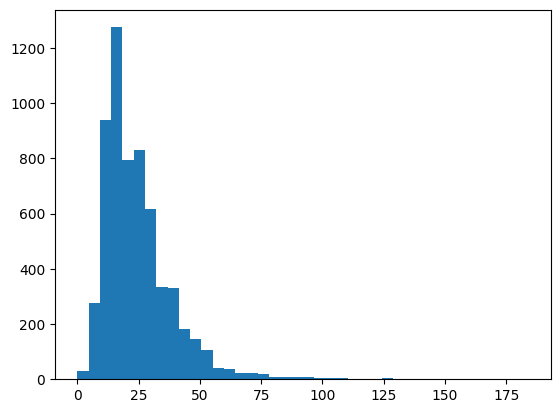

In [181]:
print('Train max length:', train_descriptions.tokens.apply(len).max())
plt.hist(train_descriptions.tokens.apply(len), bins=40)
MAX_LENGTH = 40
plt.show()

In [182]:
train_descriptions

,id,image_id,description,tokens
1,1,66667cee5b.png,ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 +...,"[124, 2, 3, 1019, 48, 39, 18, 2, 39, 3, 21, 2,..."
2,2,1cbb05a562.png,\widetilde\gamma_{\rm hopf}\simeq\sum_{n>0}\wi...,"[126, 38, 55, 1021, 196, 56, 10, 5, 126, 24, 1..."
3,3,ed164cc822.png,"({\cal L}_a g)_{ij} = 0, \ \ \ \ ({\cal L}_a H...","[44, 31, 6, 24, 79, 5, 44, 31, 6, 43, 194, 5]"
4,4,e265f9dc6b.png,S_{stat} = 2\pi \sqrt{N_5^{(1)} N_5^{(2)} N_5^...,"[30, 1022, 2, 35, 60, 10, 74, 3, 10, 74, 2, 10..."
5,5,227301e73d.png,\hat N_3 = \sum\sp f_{j=1}a_j\sp {\dagger} a_j...,"[51, 10, 26, 56, 227, 28, 23, 3, 6, 23, 227, 9..."
...,...,...,...,...
8080,8080,2f2fe07656.png,"\matrix{\sigma_{+1}((\phi,\alpha),(\psi,\beta)...","[219, 45, 3, 25, 21, 41, 47, 2, 118, 46, 30, 3..."
8082,8082,1f02eed518.png,\Pi^{0}_{c} = \frac{\partial {\cal{L}}}{\part...,"[35, 5, 36, 4, 20, 44, 31, 20, 20, 5, 6, 5, 36..."
8083,8083,2d83b5cbed.png,\delta _{i}=\partial _{i}+w_{i}\partial _{4}+n...,"[29, 7, 20, 7, 62, 7, 20, 37, 10, 7, 20, 74, 9..."
8084,8084,71bf566307.png,\label{implusphi}\lim_{x\rightarrow +\infty} \...,"[9, 4295, 165, 8, 92, 68, 25, 7, 3, 10, 3, 29,..."


# Модель

In [183]:
class DescriptionsDataset(Dataset):
    def __init__(self, tokens, embeds, tokenizer):
        super().__init__()
        self.tokens = tokens  # Expecting a DataFrame
        self.embeds = embeds  # Expecting a tensor or array-like for image embeddings
        self.tokenizer = tokenizer
        self.specials = ['<pad>', '<bos>', '<eos>', '<unk>']
        self.PAD_IDX = 0  # Index for <pad>
        self.UNK_IDX = tokenizer.word_index['<unk>']  # Index for <unk>
        self.MAX_LENGTH = 50  # Set the maximum sequence length

    def __len__(self):
        return len(self.tokens)

    def tokens_to_idx(self, tokens):
        return [self.tokenizer.word_index.get(token, self.UNK_IDX) for token in tokens]

    def encode(self, tokens):
        tokens = ['<bos>'] + tokens + ['<eos>']
        return self.tokens_to_idx(tokens)

    def decode(self, idx):
        tokens = [word for index in idx for word, word_idx in self.tokenizer.word_index.items() if word_idx == index]
        return ' '.join(token for token in tokens if token not in self.specials)

    def __getitem__(self, item):
        # Ensure self.tokens is valid and item is indices correctly
        tokens = self.tokens.iloc[item]['tokens']

        # Check if tokens is a list or needs to be converted
        if isinstance(tokens, (list, pd.Series)):  # Check if it's a list
            encoded = self.encode(tokens)[:self.MAX_LENGTH + 2]
        else:
            raise ValueError(f"Expected tokens to be list-like or Series, got {type(tokens)}")

        padded = torch.full((self.MAX_LENGTH + 2,), self.PAD_IDX, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded, dtype=torch.int64)  # Ensure tensors match types.

        # Extract image_id and ensure it's used properly
        image_id = self.tokens.iloc[item]['id']  # Assuming 'image_id' is in the DataFrame
        embedded_image = self.embeds[image_id]  # Make sure self.embeds is indexed correctly

        return padded, len(encoded), embedded_image

In [184]:
train_set = DescriptionsDataset(train_descriptions, image_embeds, tokenizer)
test_set = DescriptionsDataset(test_descriptions, image_embeds, tokenizer)

train_loader = DataLoader(train_set, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)
embeds_loader = DataLoader(test_embeds, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

In [185]:
descriptions_list = []

for image in tqdm(test_images):
    data = test_descriptions[test_descriptions.image_id == image]
    descriptions_list += [data.description.str.lower().tolist()]

100%|██████████| 2022/2022 [00:01<00:00, 1447.35it/s]


In [201]:
class DescriptionRNN(nn.Module):
    def __init__(self, image_embed_dim, tokenizer, embed_dim=256, hidden_dim=256, lstm_layers=1, dropout=0.1):
        super().__init__()
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim
        self.tokenizer = tokenizer  # Store the tokenizer as an instance variable
        self.MAX_LENGTH = 50

        self.image_embed_to_h0 = nn.Sequential(
            nn.Linear(image_embed_dim, lstm_layers * hidden_dim),
            nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = nn.Sequential(
            nn.Linear(image_embed_dim, lstm_layers * hidden_dim),
            nn.LeakyReLU(0.1),
        )

        self.embedding = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.linear = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, VOCAB_SIZE)
        )

    def forward(self, tokens, lengths, image_embeds):
      B = image_embeds.shape[0]

      # Reshape image_embeds
      image_embeds = image_embeds.view(B, -1)  # Ensuring it becomes (B, 1280)

      h0 = self.image_embed_to_h0(image_embeds).view(self.lstm_layers, B, self.hidden_dim)
      c0 = self.image_embed_to_c0(image_embeds).view(self.lstm_layers, B, self.hidden_dim)

      # Get token embeddings
      embeds = self.embedding(tokens)

      # Move lengths to CPU
      lengths = lengths.cpu()

      packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
      outputs, (h, c) = self.lstm(packed_embeds, (h0, c0))
      outputs, lengths = pad_packed_sequence(outputs, batch_first=True)

      # Ensure correct shape before passing to linear layer
      outputs_reshaped = outputs.contiguous().view(-1, self.hidden_dim)  # (B * L, hidden_dim)

      logits = self.linear(outputs_reshaped)  # Ensure this is fine with dimensions

      # Final reshaping to (B, L, vocab_size)
      logits = logits.view(B, -1, self.linear[1].weight.size(0))

      return logits

    @torch.no_grad()
    def inference(self, image_embeds):
        self.eval()
        B = image_embeds.shape[0]
        h = self.image_embed_to_h0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        h, c = h.contiguous(), c.contiguous()

        # Initialize tokens with <bos>
        tokens = torch.full((B, 1), self.tokenizer.word_index['<bos>'], device=image_embeds.device)

        # Loop until we reach maximum length or encounter <eos> token
        while tokens.shape[1] < self.MAX_LENGTH:
            if ((tokens == self.tokenizer.word_index['<eos>']).sum(1) > 0).all():
                break

            # Process newly obtained token
            embeds = self.embedding(tokens)  # Use the current tokens for embedding
            output, (h, c) = self.lstm(embeds, (h, c))
            logits = self.linear(output)

            # Get new tokens from logits
            new_tokens = logits[:, -1, :].argmax(dim=-1, keepdim=True)  # Get the last token output
            tokens = torch.cat([tokens, new_tokens], dim=1)

        return tokens


In [191]:
print(f"tokens shape: {tokens.shape}")
print(f"lengths shape: {lengths.shape}")
print(f"embeds shape: {embeds.shape}")

tokens shape: torch.Size([256, 52])
lengths shape: torch.Size([256])
embeds shape: torch.Size([256, 1280, 1, 1])


# Обучение

In [207]:
BLEU_FREQ = 5

def plot_losses(train_losses, test_losses, test_blues):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test', color='springgreen', linewidth=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(BLEU_FREQ * np.arange(1, len(test_blues) + 1), test_blues, label='test',
                color='springgreen', linewidth=2)
    axs[1].set_ylabel('BLEU')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [208]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss = 0.0
    model.train()
    for tokens, lengths, embeds in tqdm(train_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        tokens = tokens[:, :lengths.max()].to(device)

        optimizer.zero_grad()
        logits = model(tokens[:, :-1], lengths - 1, embeds)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embeds.shape[0]

    train_loss /= len(train_loader.dataset)
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss = 0.0
    model.eval()
    for tokens, lengths, embeds in tqdm(valid_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        tokens = tokens[:, :lengths.max()].to(device)

        logits = model(tokens[:, :-1], lengths - 1, embeds)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])

        valid_loss += loss.item() * embeds.shape[0]

    valid_loss /= len(valid_loader.dataset)
    return valid_loss


def evaluate_bleu(model, embeds_loader, descriptions):
    bleu = BLEUScore()
    predictions = []
    model.eval()
    for embeds in tqdm(embeds_loader, desc='Evaluating BLEU'):
        tokens = model.inference(embeds.to(device)).cpu()
        for token_list in tokens:
            predictions += [train_set.decode(token_list)]

    return bleu(predictions, descriptions).item()


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader,
          embeds_loader, descriptions_list, num_epochs):
    train_losses, valid_losses, valid_blues = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if epoch % BLEU_FREQ == 0:
            valid_bleu = evaluate_bleu(model, embeds_loader, descriptions_list)
            valid_blues += [valid_bleu]

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses, valid_blues)

In [213]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc, accumulation_steps=4):
    train_loss = 0.0
    model.train()
    optimizer.zero_grad()  # Сброс градиентов перед началом эпохи

    for i, (tokens, lengths, embeds) in enumerate(tqdm(train_loader, desc=tqdm_desc)):
        embeds = embeds.to(device)
        tokens = tokens[:, :lengths.max()].to(device)

        # Forward pass
        logits = model(tokens[:, :-1], lengths - 1, embeds)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()  # Накопление градиентов

        # Обновление весов после указанных шагов накопления
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()  # Обновление весов модели
            optimizer.zero_grad()  # Удаление градиентов для следующего накопления

        train_loss += loss.item() * embeds.shape[0]

    # Обработка всех оставшихся градиентов, если общее количество пакетов не кратно шагу накопления.
    if len(train_loader) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(train_loader.dataset)
    return train_loss

@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss = 0.0
    model.eval()
    for tokens, lengths, embeds in tqdm(valid_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        tokens = tokens[:, :lengths.max()].to(device)

        logits = model(tokens[:, :-1], lengths - 1, embeds)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])

        valid_loss += loss.item() * embeds.shape[0]

    valid_loss /= len(valid_loader.dataset)
    return valid_loss

def evaluate_bleu(model, embeds_loader, descriptions):
    bleu = BLEUScore()
    predictions = []
    model.eval()
    for embeds in tqdm(embeds_loader, desc='Evaluating BLEU'):
        tokens = model.inference(embeds.to(device)).cpu()
        for token_list in tokens:
            predictions += [train_set.decode(token_list)]

    return bleu(predictions, descriptions).item()

def train(model, optimizer, scheduler, criterion, train_loader, valid_loader,
          embeds_loader, descriptions_list, num_epochs):
    train_losses, valid_losses, valid_blues = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if epoch % BLEU_FREQ == 0:
            valid_bleu = evaluate_bleu(model, embeds_loader, descriptions_list)
            valid_blues += [valid_bleu]

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses, valid_blues)

        # Очистка кеша от неиспользованных тензоров
        torch.cuda.empty_cache()
        gc.collect()
        # вывод сводки использования памяти GPU
        print(f"После эпохи {epoch}:")
        print(torch.cuda.memory_summary(device=device, abbreviated=True))

# Ensure to set the device appropriately
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [210]:
NUM_EPOCHS = 5

model = DescriptionRNN(image_embeds.shape[1], tokenizer=tokenizer, dropout=0.3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = None
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

sum(param.numel() for param in model.parameters())

3388108

In [214]:
print(f'Random BLEU: {evaluate_bleu(model, embeds_loader, descriptions_list):.4f}')

Evaluating BLEU: 100%|██████████| 8/8 [33:19<00:00, 249.95s/it]


Random BLEU: 0.0000


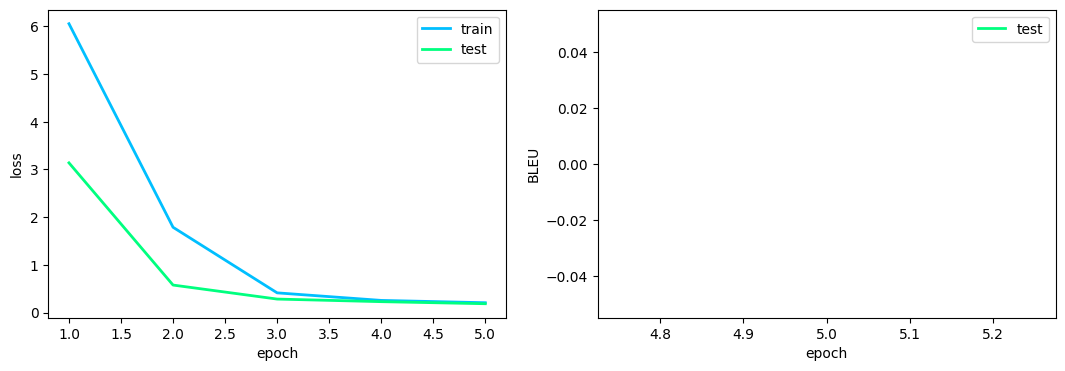

После эпохи 5:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 475749 KiB |   5690 MiB |   2172 GiB |   2172 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 475749 KiB |   5690 MiB |   2172 GiB |   2172 GiB |
|---------------------------------------------------------------------------|
| Requested memory      | 473331 KiB |   5689 MiB |   2170 GiB |   2170 GiB |
|------------------------------------------------

In [215]:
train(model, optimizer, scheduler,
      criterion, train_loader, test_loader,
      embeds_loader, descriptions_list, NUM_EPOCHS)

# Результат генерации

Prediction: 
GT description #1: D_I = \sum_{a=1}^{N} q_I^a \left( |h_a|^2 - |\tilde h_a|^2 \right),\label{Dterm}


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


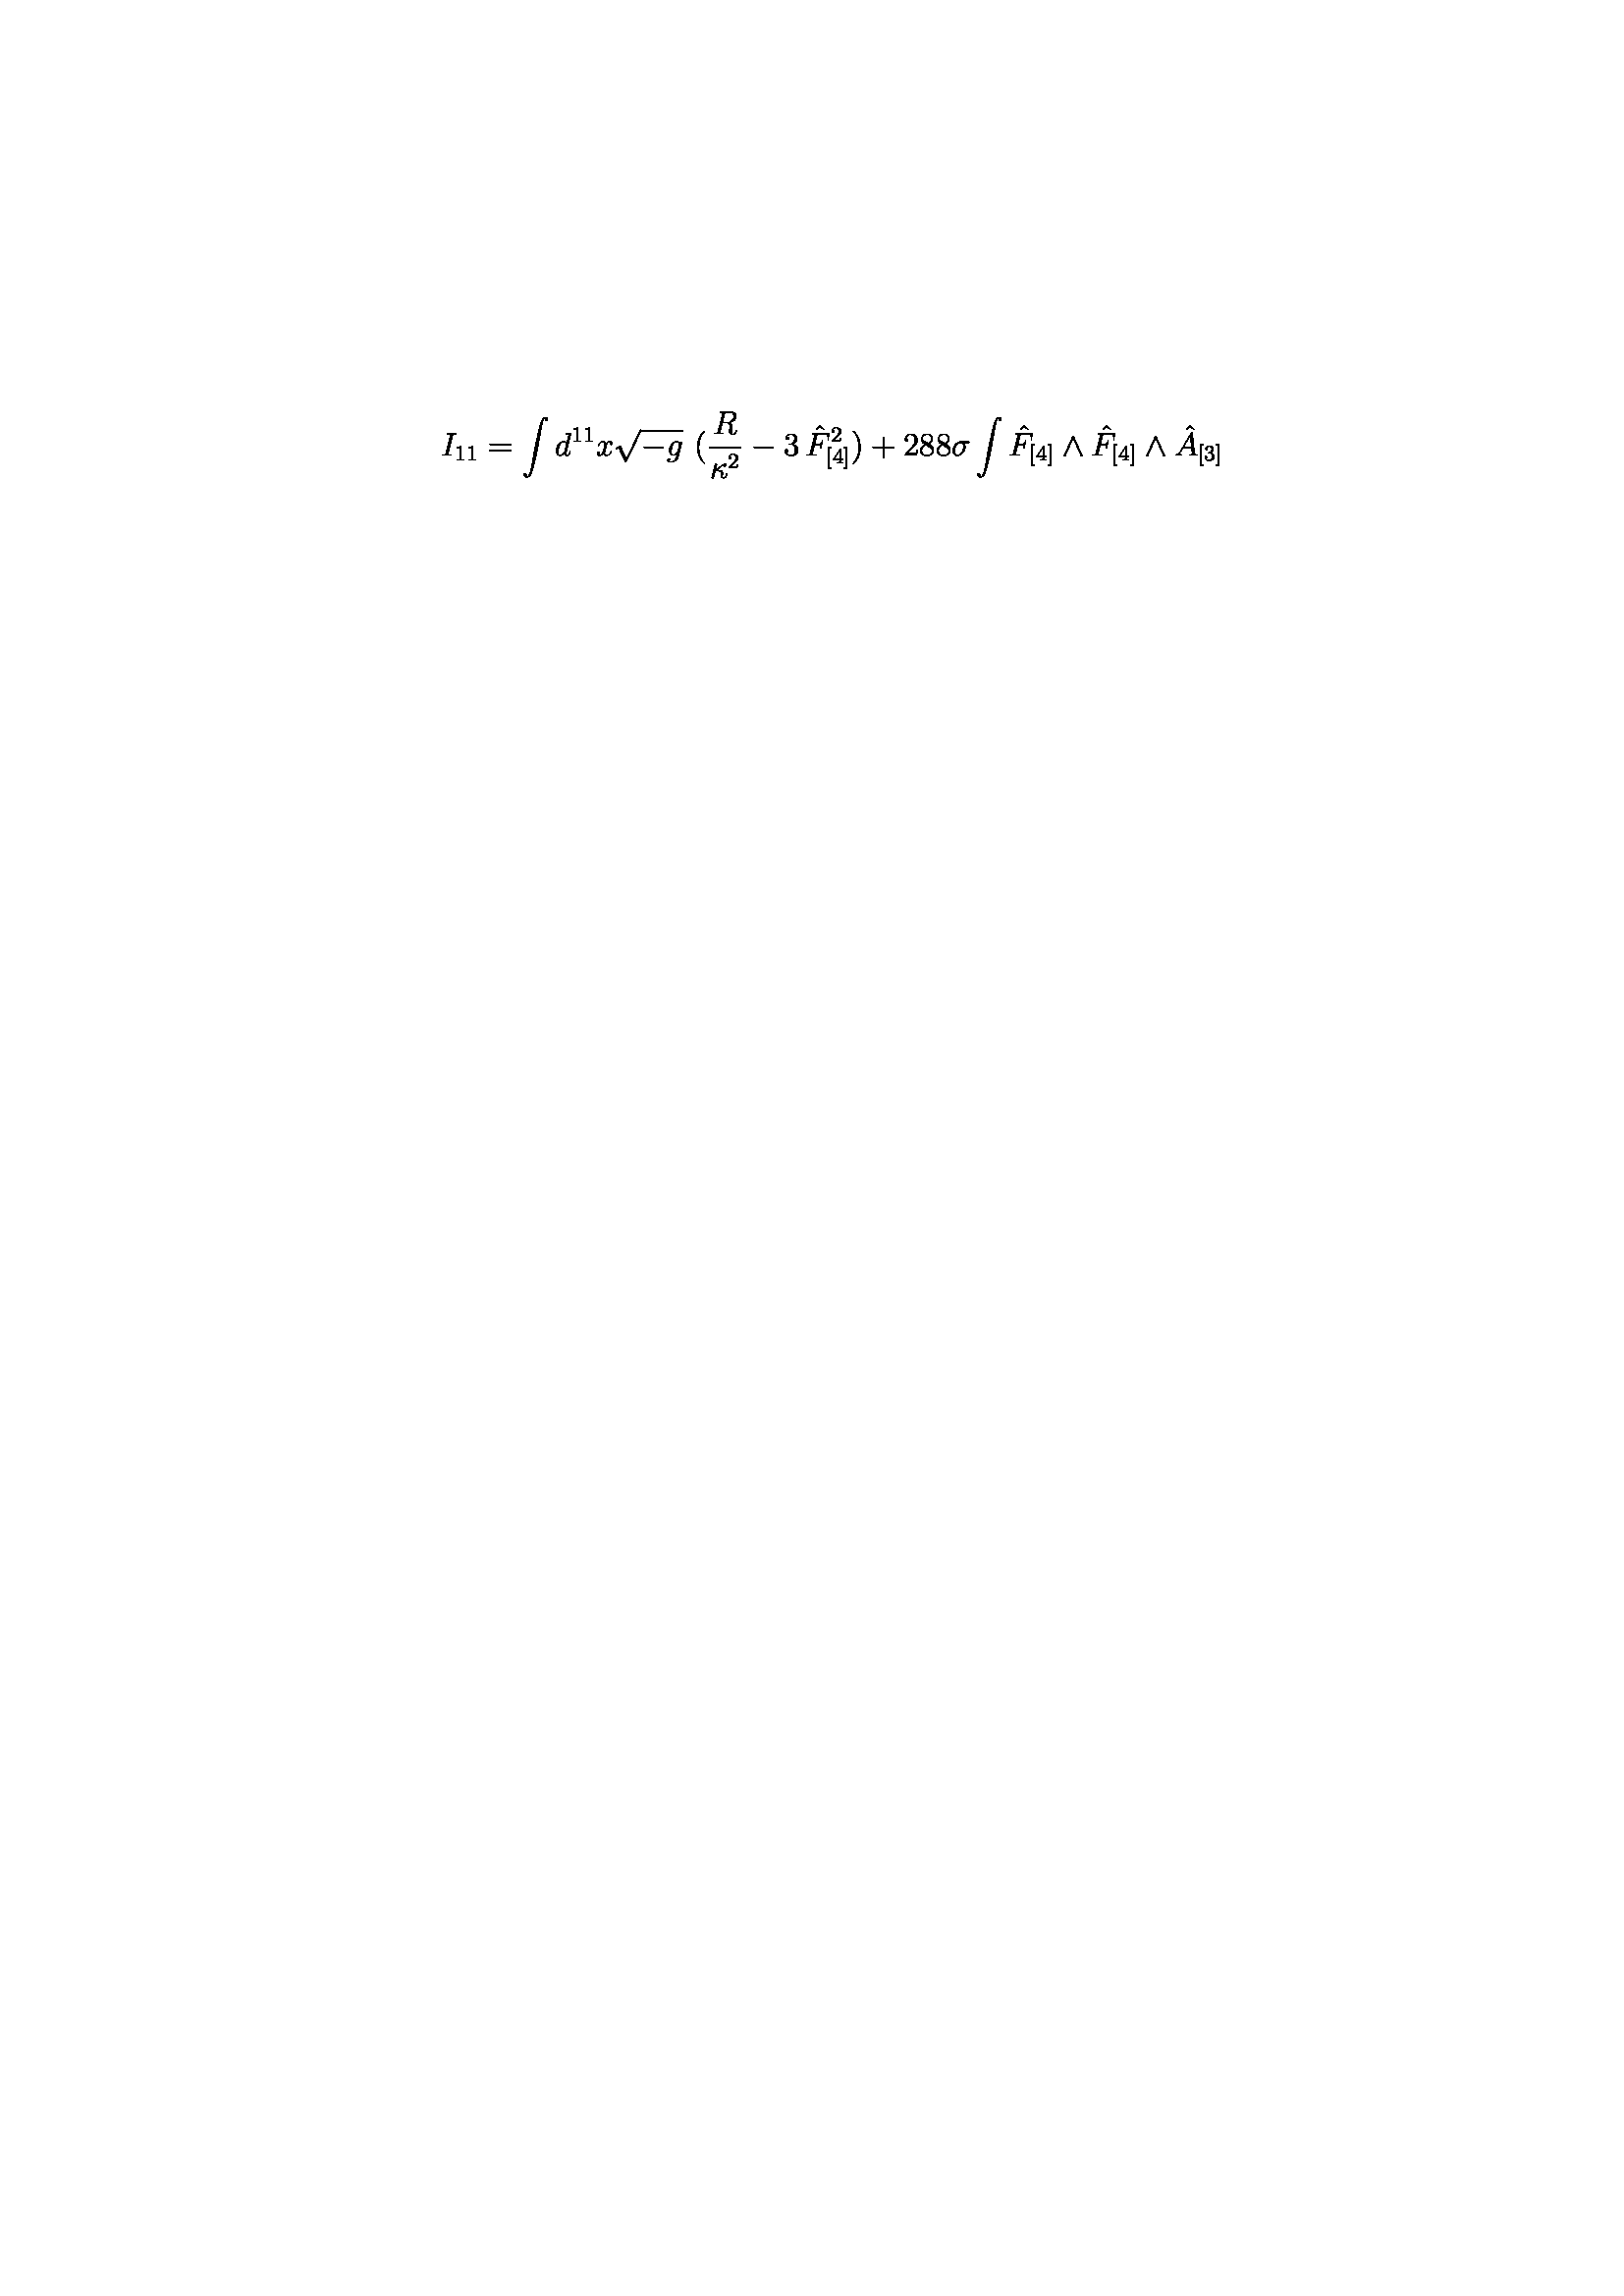

In [218]:
def description_random_test_image():
    index = np.random.randint(len(test_images))
    image_file = test_images[index]
    tokens = model.inference(image_embeds[index].unsqueeze(0).to(device)).cpu().squeeze()
    prediction = train_set.decode(tokens)
    print('Prediction:', prediction)

    for i, description in enumerate(descriptions[descriptions.image_id == image_file].description):
        print(f'GT description #{i + 1}:', description)

    return Image.open(os.path.join('/content/formula_images', image_file)).convert('RGB')

description_random_test_image()